# Cleaning Events data

### Importing necessary libraries

In [1]:
pip install pandas matplotlib seaborn wordcloud

  Using cached pandas-1.5.0-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.2 MB)
  Using cached matplotlib-3.6.0-cp38-cp38-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (9.4 MB)
  Using cached seaborn-0.12.0-py3-none-any.whl (285 kB)
  Using cached wordcloud-1.8.2.2-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (458 kB)
  Using cached numpy-1.23.3-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.1 MB)
  Using cached pytz-2022.4-py2.py3-none-any.whl (500 kB)
  Using cached Pillow-9.2.0-cp38-cp38-manylinux_2_28_x86_64.whl (3.2 MB)
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
  Using cached fonttools-4.37.4-py3-none-any.whl (960 kB)
  Using cached contourpy-1.0.5-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (295 kB)
  Using cached kiwisolver-1.4.4-cp38-cp38-manylinux_2_5_x86_64.manylinux1_x86_64.whl (1.2 MB)
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

### Loading the data

In [3]:
events = pd.read_csv('../sources/events.csv')
registered = pd.read_csv('../sources/registered_in_events.csv')

## Data Cleaning

**Cleaning events**

In [4]:
#Useless columns

TO_DROP_EVENTS = ['created_at','updated_at','organization_id']

#Drop useless columns in events

events.drop(TO_DROP_EVENTS, axis=1, inplace=True)

#Drop null columns in events
events.dropna(axis=1, how='all', inplace=True)



**Cleaning registered_in_events**

In [5]:
TO_DROP_REGISTERED = ['id', 'created_at','updated_at','status']

#Drop useless columns in registered_in_events

registered.drop(TO_DROP_REGISTERED, axis=1, inplace=True)

#Drop null columns in registered
registered.dropna(axis=1, how='all', inplace=True)

#Drop null columns in registered
registered.dropna(axis=1, how='all', inplace=True)

**Joining both datasets**

In [6]:
merged = pd.merge(registered, events, left_on="event_id", right_on="id").drop(['id','excerpt','eventbrite_sync_description','eventbrite_url','eventbrite_id','banner'], axis=1)
merged.shape

(4888, 22)

**Cleaning merged dataframe**

In [7]:
merged['starting_at'] = merged['starting_at'].apply(pd.to_datetime)
merged['ending_at'] = merged['ending_at'].apply(pd.to_datetime)
merged['published_at'] = merged['published_at'].apply(pd.to_datetime)

#Changing format
merged['starting_at'] = merged['starting_at'].dt.strftime('%Y-%m-%d %H:%M:%S')
merged['ending_at'] = merged['ending_at'].dt.strftime('%Y-%m-%d %H:%M:%S')
merged['published_at'] = merged['published_at'].dt.strftime('%Y-%m-%d %H:%M:%S')

#Format change also changed the column type to object, so we need to convert it to datetime again 
merged['starting_at'] = merged['starting_at'].apply(pd.to_datetime)
merged['ending_at'] = merged['ending_at'].apply(pd.to_datetime)
merged['published_at'] = merged['published_at'].apply(pd.to_datetime)

In [8]:
#Replacing commas in certain columns

merged['tags'] = merged['tags'].str.replace(',', ' ')
merged['description'] = merged['description'].str.replace(',', ' ')
merged['title'] = merged['title'].str.replace(',', ' ')

#Replacing nulls with 'undefined'

merged = merged.replace(np.nan, 'Undefined', regex=True)

In [9]:
#Assign language to events with missing info.

merged['lang'] = np.where((merged['event_id'].isin([35,36,38,40,414,37,130,123,41,122,141,42,146,125,145,46,48,47,49,131,
                                                    127,85,86,84,121,128,119,181,189,184,135,134,136,182,192,193,137,138,
                                                    139,186,195,198,217,196,213,203,212,205,204,209,211,218,262,339,268,
                                                    260,263,142,183,140,432,261,363,264,344,340,308,316])),'es', merged['lang'])

merged['lang'] = np.where((merged['event_id'].isin([39,43,187,45,44,190,144,50,51,126,180,191,132,129,120,185,188,197,200,
                                                    194,199,201,202,206,216,208,252,214,251,254,368,357,124,207,210,215])),'en', merged['lang'])

In [10]:
#create a event tags dataframe to explode tags

tags_df = merged.groupby(['event_id','title','tags'])['tags'].agg(['count']).reset_index()

In [11]:
tags_df.rename(columns = {'count':'attendies'}, inplace = True)
tags_df.shape

(149, 4)

In [12]:
#converting tags column in a list instead of string

tags_df['tags'] = tags_df.tags.apply(lambda x: x.split(' '))

In [13]:
#Exploding the list to rows

tags_df = tags_df.explode('tags').drop_duplicates()

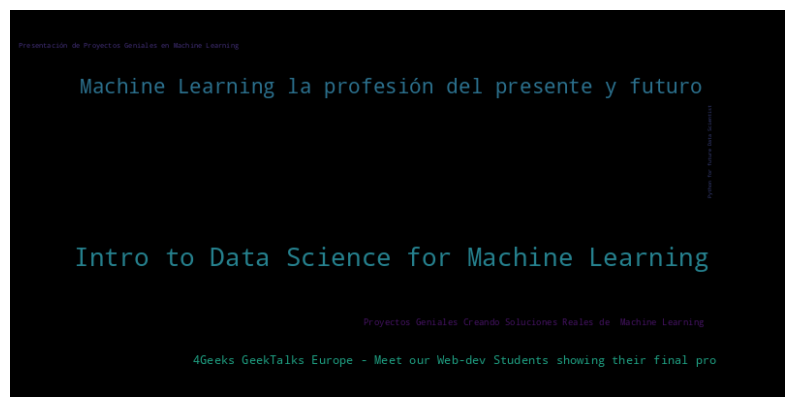

In [14]:
#Creating a word cloud

import matplotlib.pyplot as plt
from wordcloud import WordCloud


df_wc = tags_df[(tags_df['tags'] =='tech-machinelearning')]

df_wc = df_wc[['title','attendies']]
df_wc = df_wc.set_index('title').to_dict()['attendies']

wc = WordCloud(width=800, height=400, max_words=200,).generate_from_frequencies(df_wc)
plt.figure(figsize=(10, 10))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

In [15]:
'''
tag_dict = {}

for row in df3:
    for tag in row['tags'].split(" "):
        if tag not in tag_dict:
            tag_dict[tag] = int(row['attendies'])
        else:
            tag_dict[tag] += int(row['attendies'])
'''

'\ntag_dict = {}\n\nfor row in df3:\n    for tag in row[\'tags\'].split(" "):\n        if tag not in tag_dict:\n            tag_dict[tag] = int(row[\'attendies\'])\n        else:\n            tag_dict[tag] += int(row[\'attendies\'])\n'

In [16]:
#Saving joined dataset

merged.to_csv('../output/events_and_attendies.csv')
tags_df.to_csv('../output/tags_df.csv')

**When joining with form_entries**

In [17]:
#final_df = pd.merge(merged, forms[['email','lead_type', 'country','deal_status','won_at']],on='email', how='inner')
#final_df.shape